# CUDA Analysis

This notebook contains the analysis of the CUDA implementation for two different problems: the Pi number calculation and a vector/matrix multiplication.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Pi number computation

The first problem to analyze is the computation of the Pi number using the Monte Carlo method. This will be implemented in 4 different ways:
  - Using the GPU with a single thread and a multiple blocks.
  - Using the GPU with multiple threads and a multiple block. Global variable between used by the threads of each block, the first thread sum the result of the block and save it in the partial result vector (one slot per block).
  - Using the GPU with multiple threads and a multiple block. Each thread add its result to the partial result vector of its block using an atomic operation.
  - Using the GPU with multiple threads and a multiple block. The result of each block is computed using a reduction algorithm and a shared memory for each block. The first thread is the last one alive in the reduction algorithm, therefore it writes the result of the block in the partial result vector.

### Compilation and performance evaluation

In [34]:
!make pi
!make pi_mt
!make pi_atomic
!make pi_msr

In [38]:
df_pi_1_thread = pd.read_csv("pi.csv")
df_pi_mt = pd.read_csv("pi_mt.csv")
df_pi_atomic = pd.read_csv("pi_atomic.csv")
df_pi_msr = pd.read_csv("pi_msr.csv")

df_pi_1_thread["method"] = "1_thread"
df_pi_mt["method"] = "n_threads"
df_pi_atomic["method"] = "atomic"
df_pi_msr["method"] = "reduction"

df_pi = pd.concat([df_pi_1_thread, df_pi_mt, df_pi_atomic, df_pi_msr])
df_pi

,num_steps,num_blocks,num_threads,thread_steps,result,runtime,method
0,1000000,1000000,1,1,6.28318,0.108293,1_thread
1,1000000,1000000,1,1,6.28318,0.073274,1_thread
2,1000000,1000000,1,1,6.28318,0.070989,1_thread
3,1000000,1000000,1,1,6.28318,0.106158,1_thread
4,1000000,1000000,1,1,6.28318,0.071560,1_thread
...,...,...,...,...,...,...,...
795,1000000000,3814,256,1024,3.14123,0.404402,reduction
796,1000000000,3814,256,1024,3.14123,0.337812,reduction
797,1000000000,3814,256,1024,3.14123,0.279991,reduction
798,1000000000,3814,256,1024,3.14123,0.281200,reduction


In [39]:
df_pi.describe()

,num_steps,num_blocks,num_threads,thread_steps,result,runtime
count,2.560000e+03,2.560000e+03,2560.000000,2560.000000,2560.000000,2560.000000
mean,2.777500e+08,1.849389e+07,90.250000,336.250000,2.890939,1.165950
std,4.188660e+08,1.243636e+08,90.434408,408.109357,0.959588,4.057685
min,1.000000e+06,3.000000e+00,1.000000,1.000000,0.000000,0.035345
25%,7.750000e+06,7.620000e+02,24.250000,48.250000,3.122835,0.132560
50%,5.500000e+07,1.525800e+04,64.000000,160.000000,3.141045,0.223543
75%,3.250000e+08,3.125000e+05,128.000000,448.000000,3.141590,0.362749
max,1.000000e+09,1.000000e+09,256.000000,1024.000000,6.283190,67.479900


### Performance analysis

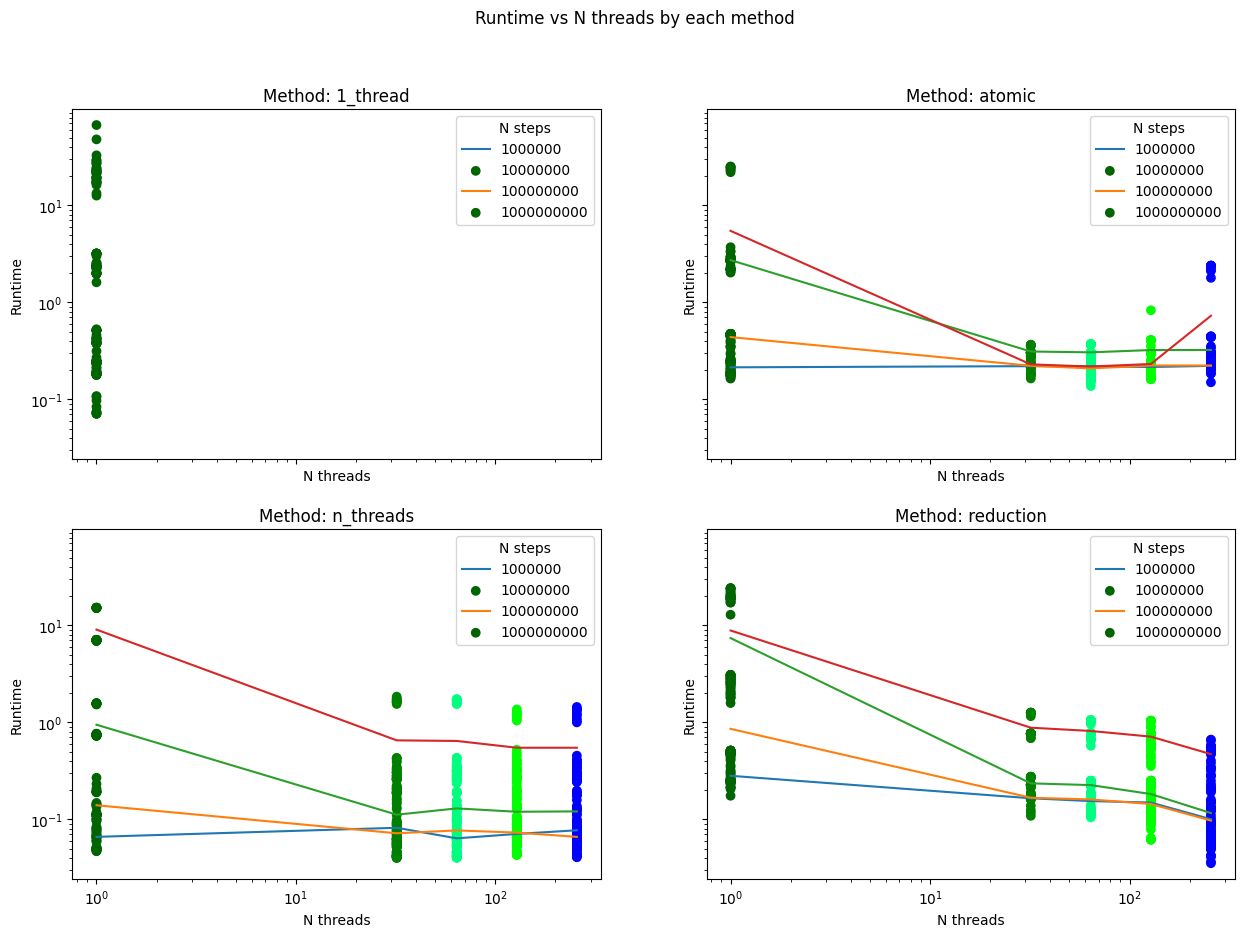

In [10]:
color_num_steps = {1 : "darkgreen", 32 : "green", 64 : "springgreen", 128 : "lime", 256: "blue"}
ax_methods = { "1_thread": [0,0], "n_threads": [1, 0], "atomic": [0, 1], "reduction": [1, 1]}

x = 'num_steps'
y = 'runtime'

fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

for x_value in df_pi[x].unique():
    for method in df_pi['method'].unique(): 
        ax_x, ax_y = ax_methods[method];
        ax = axs[ax_x, ax_y]

        df_x_value = df_pi[(df_pi[x] == int(x_value))]
        df_plot = df_x_value[df_x_value['method'] == method]
        
        mean_stats = df_plot.groupby([x,'method', 'num_threads']).mean().reset_index()
        
        ax.plot(mean_stats['num_threads'], mean_stats[y], linestyle="solid")
        sct = ax.scatter(df_plot['num_threads'], df_plot[y], c=df_plot['num_threads'].apply(lambda n : color_num_steps[n]))
        ax.set_xlabel("N threads")
        ax.set_ylabel("Runtime")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title("Method: " + method)
        ax.legend(title="N steps", labels=[1000000, 10000000, 100000000, 1000000000])
    
fig.suptitle('Runtime vs N threads by each method', fontsize='large')
plt.show()

In the previous diagrams, we can see the comparaison between the 4 implementation according the number of threads used vs the runtime. 

We can see than more threads we use for the reduction implementation, faster the execution. However, the differences in runtime for the atomic method don't change sufficiently to affirm the same. This is due to the fact that there's a bottleneck in the atomicity of the variable that is being handle by multiple threads. This bottleneck doesn't allow the parallelization to continue increasing its performance. In the other side, the reduction method doesn't have that bottleneck, due to it is not using an atomic variable, instead it is using a shared memory between the threads and computing partial results in batches while reducing the amount of running thread after each iteration. This allows the parallelization to increase the performance due to more threads we have more parallelize is the logic (smaller batches).

The counter side of having too many blocks/threads is the loss of precision, this happens due to we're using the float type instead of the double type. Therefore, more singular operations we have, more precision we're going to lose. To avoid this it is possible to use types with a bigger precision like `double` or try to achieve a balance between the the amount of blocks/threads.

We can see that a clear winner for complex tasks the require big amount of data is the reduction approach, due to it's runtime decrease when we allow it to have more threads. For simple tasks, the N threads approach is the best one, due to it's simplicity and lack of bottleneck.

Text(0.5, 0.98, 'Runtime Analysis of each method by N steps')

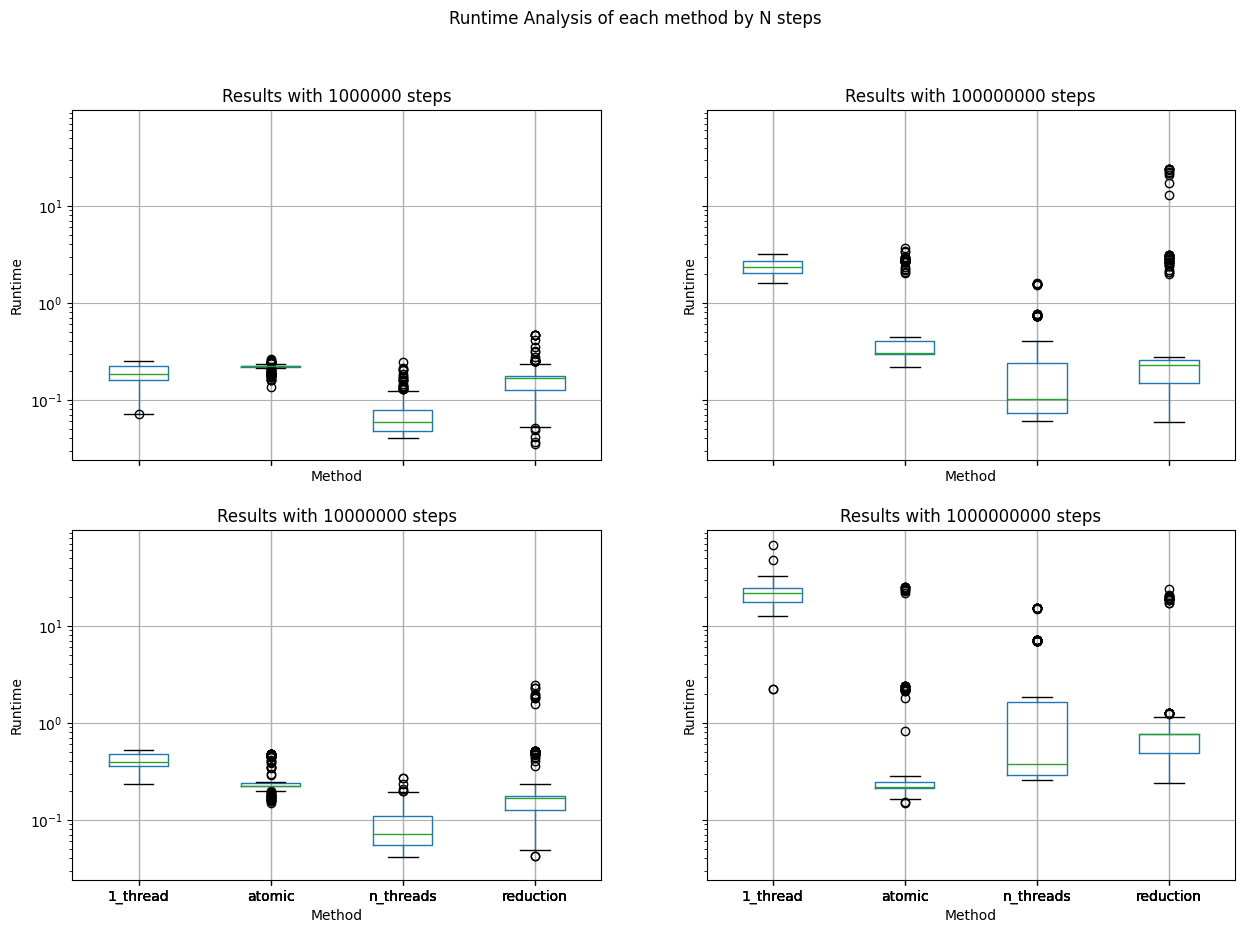

In [9]:
ax_num_steps = { 1000000: [0,0], 10000000: [1, 0], 100000000: [0, 1], 1000000000: [1, 1]}

fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

for x_value in df_pi['num_steps'].unique():
  ax_x, ax_y = ax_num_steps[x_value];
  ax = axs[ax_x, ax_y]

  df_x_value = df_pi[(df_pi['num_steps'] == int(x_value))]
  df_threads = df_x_value.pivot(columns='method', values='runtime')
  df_threads.boxplot(ax=ax)
  plt.yscale('log')
  ax.set_title('Results with ' + str(x_value) + ' steps')
  ax.set_xlabel('Method')
  ax.set_ylabel('Runtime')

fig.suptitle('Runtime Analysis of each method by N steps', fontsize='large')

In the latest diagram, we have the general results of all executions, all the number of threads and steps with a repetition of 10 times by each execution. They are divided by method and by N steps.

As we can see, for lower N steps, the overall performance of all the methods is similar. However, when we increase the N steps they start showing differences. 

The 1 thread approach is always reducing its performance as we add more N steps. This is due to the overall execution is not parallelized, therefore, the more N steps we have, the more sequential iterations it takes to compute the result.

The atomic approach has a constant performance, even if there's more case with wrong performance as the N steps increase. This is due to the fact that the atomicity of the variable is a bottleneck, therefore, the more N steps we have, the more threads we have, the more bottleneck we have. This is the reason why the atomic approach has a constant performance. In other words, it's performance is increased by the amount of threads but reduced by the bottleneck of the atomicity. This creates a balance that conduce the the result we can see in the diagram, where the runtime mean is almost constant.

The N threads approach (global var) is considerable better than the others approach for lower N steps. However, as the N steps increase, the performance of this approach is reduced. This is due to the fact that the more N steps we have, the more threads we can have depending on the steps per thread and this is the main cause of the increasingly variance of the N threads approach. This approach has a strong dependency on the combination of number of blocks, threads and steps per thread. This is the reason why the performance of this approach is not constant and its variance is increasing. This dependency happens due to the approach is using a global variable to store the partial results of each block and aggregating the results of a block sequentially after all threads end their calculation. In other words, more thread we have more sequentially operations we have to do to aggregate the results of each block.

The reduction approach has a almost constant performance close to e-1 for the first cases and in the last one we can see it is increasing with some low performance execution close to e1. This is due to the fact that the reduction approach is using a shared memory to store the partial results of each block and aggregating the results of a block in parallel by using reduction. This allows the approach to have a constant performance as the N steps increase. In other words, more threads we have, more parallel operations we have to do to aggregate the results of each block.

## Vector

The second problem to analyze is the vector/matrix multiplication. This will be implemented in 4 different ways:
  - Using the GPU with a single thread and a multiple blocks, one for each row of the matrix.
  - Using the GPU with multiple threads and a multiple block. Each thread add its result to the partial result vector of its block using an atomic operation.
  - Using the GPU with multiple threads and a multiple block. The result of each block is computed using a reduction algorithm and a shared memory for each block. The first thread is the last one alive in the reduction algorithm, therefore it writes the result of the block in the partial result vector.

### Compilation and performance evaluation

In [ ]:
!make vector
!make vector_atomic
!make vector_shared

### Performance analysis

In [40]:
df_vector = pd.read_csv("vector.csv")
df_atomic = pd.read_csv("vector_atomic.csv")
df_shared = pd.read_csv("vector_shared.csv")


df_vector["method"] = "1_thread"
df_atomic["method"] = "atomic"
df_shared["method"] = "shared"

df_vector_methods = pd.concat([df_vector, df_atomic, df_shared])

df_vector_methods["S"] = df_vector_methods["N"] * df_vector_methods["M"]
df_vector_methods

,num_threads,N,M,Gbytes,time,method,S
0,1,4,2,1.120000e-07,0.048756,1_thread,8
1,1,4,2,1.120000e-07,0.048397,1_thread,8
2,1,4,2,1.120000e-07,0.084582,1_thread,8
3,1,4,2,1.120000e-07,0.091252,1_thread,8
4,1,4,2,1.120000e-07,0.206823,1_thread,8
...,...,...,...,...,...,...,...
275,8,32768,16384,4.295360e+00,0.343677,shared,536870912
276,8,32768,16384,4.295360e+00,0.337765,shared,536870912
277,8,32768,16384,4.295360e+00,0.337573,shared,536870912
278,8,32768,16384,4.295360e+00,0.338599,shared,536870912


In [41]:
df_vector_methods.describe()

,num_threads,N,M,Gbytes,time,S
count,630.000000,630.000000,630.000000,6.300000e+02,630.000000,6.300000e+02
mean,3.444444,7792.571429,3896.285714,7.772759e-01,0.140234,9.714778e+07
std,2.673415,11566.492120,5783.246060,1.483400e+00,0.147261,1.854083e+08
min,1.000000,4.000000,2.000000,1.120000e-07,0.038824,8.000000e+00
25%,1.000000,16.000000,8.000000,1.216000e-06,0.049870,1.280000e+02
50%,2.000000,1024.000000,512.000000,4.206590e-03,0.075985,5.242880e+05
75%,4.000000,16384.000000,8192.000000,1.073940e+00,0.149156,1.342177e+08
max,8.000000,32768.000000,16384.000000,4.295360e+00,0.997361,5.368709e+08


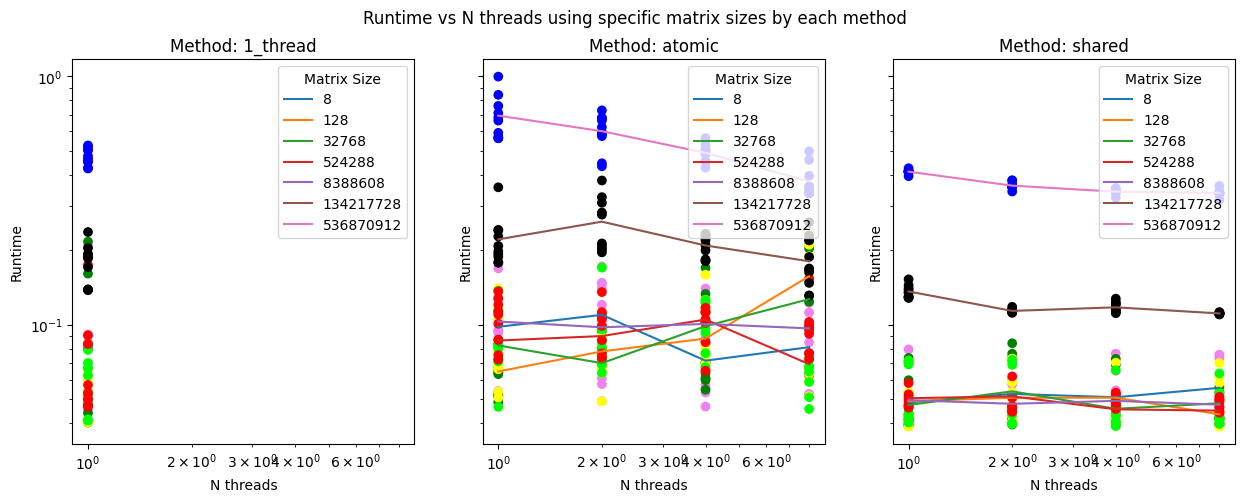

In [37]:
color_num_threads = {1 : "darkgreen", 2 : "green", 4 : "springgreen", 8 : "lime"}
ax_methods = { "1_thread": [0,0], "atomic": [1, 0], "shared": [2, 0]}
color_s = {8 : "violet", 128 : "green", 32768 : "yellow", 524288 : "lime", 8388608: "red", 134217728: "black", 536870912: "blue"}

x = 'S'
y = 'time'

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for x_value in df_vector_methods[x].unique():
    for method in df_vector_methods['method'].unique(): 
        ax_x, ax_y = ax_methods[method];
        ax = axs[ax_x]

        df_x_value = df_vector_methods[(df_vector_methods[x] == int(x_value))]
        df_plot = df_x_value[df_x_value['method'] == method]
        
        mean_stats = df_plot.groupby([x,'method', 'num_threads']).mean().reset_index()
        
        ax.plot(mean_stats['num_threads'], mean_stats[y], linestyle="solid", label=x_value)
        sct = ax.scatter(df_plot['num_threads'], df_plot[y], c=df_plot['S'].apply(lambda n : color_s[n]), label=None)
        ax.set_xlabel("N threads")
        ax.set_ylabel("Runtime")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title("Method: " + method)
        ax.legend(title="Matrix Size")
    
fig.suptitle('Runtime vs N threads using specific matrix sizes by each method', fontsize='large')
plt.show()

In the previous diagram we can see the comparaison between the 3 methods according the number of threads used vs the runtime. 

We can see than more threads we use for the reduction implementation, faster the execution for higher amount of steps.

The 1 thread approach has a similar performance than the atomic approach with 8 threads. This a due to the well mentioned bottleneck in the atomicity that makes the sequential approach similar to the atomic approach. However, the atomic approach has a increasingly better performance as more threads we use. This is due to the fact that the atomic approach is using a shared variable to store the partial results of each block and aggregating the results of a block sequentially after all threads end their calculation. In other words, more thread we have more sequentially operations we have to do to aggregate the results of each block.

The reduction approach has a almost constant performance for smaller amount of steps and a increasingly better performance for higher amounts of steps. This is due to the fact that the reduction approach is using a shared memory to store the partial results of each block and aggregating the results of a block in parallel by using reduction. This allows the approach to have a constant performance as the N steps increase. In other words, more threads we have, more parallel operations we have to do to aggregate the results of each block. 

Text(0.5, 1.0, 'Runtime Analysis of each method by matrix size')

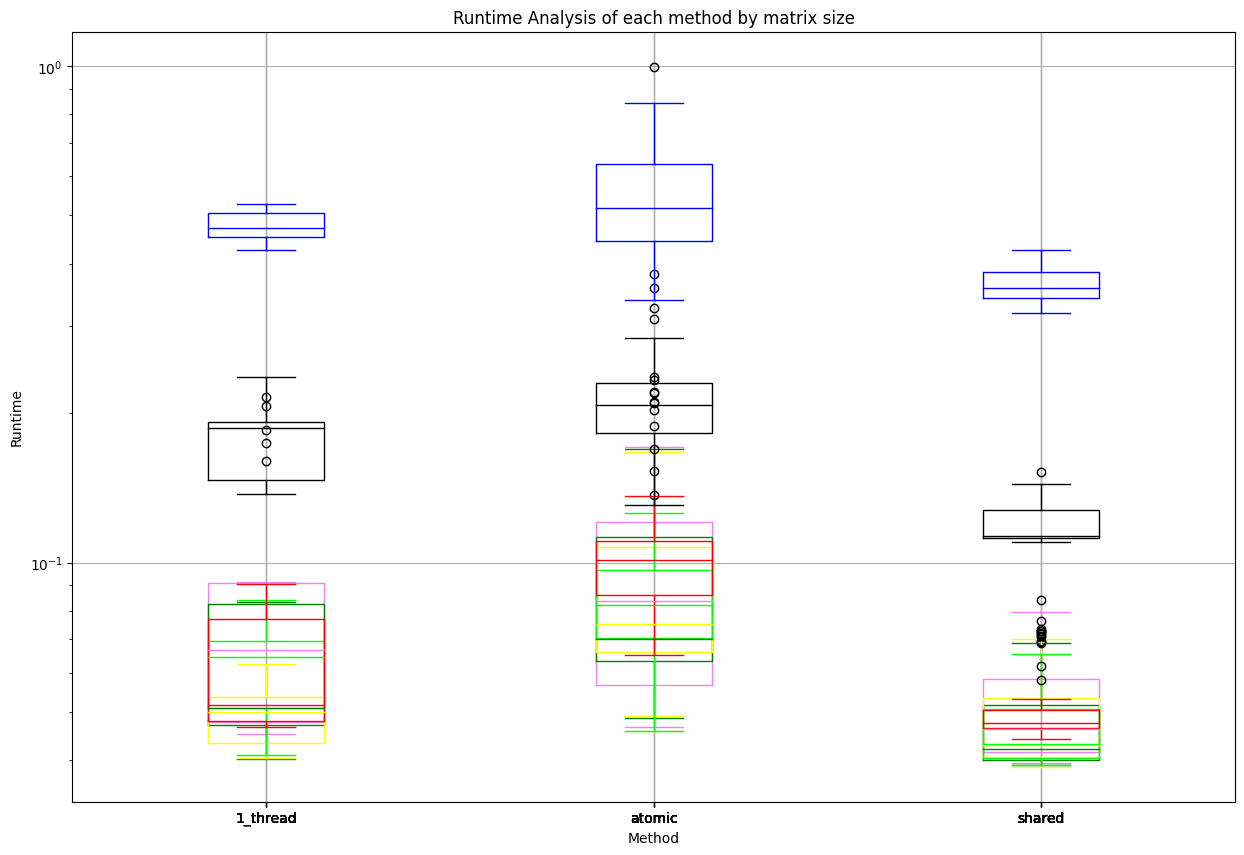

In [26]:
color_s = {8 : "violet", 128 : "green", 32768 : "yellow", 524288 : "lime", 8388608: "red", 134217728: "black", 536870912: "blue"}

x = 'S'

fig, axs = plt.subplots(1, 1, figsize=(15, 10))

for x_value in df_vector_methods[x].unique():
  df_x_value = df_vector_methods[(df_vector_methods[x] == int(x_value))]
  df_threads = df_x_value.pivot(columns='method', values='time')
  df_threads.boxplot(ax=axs, color=color_s[x_value])

plt.yscale('log')
plt.xlabel('Method')
plt.ylabel('Runtime')
plt.title('Runtime Analysis of each method by matrix size', fontsize='large')

In the latest diagram, we have the general results of all executions, all the number of threads and matrix sizes. The idea is to visualize the mean, medium and standard deviation of each method for each matrix size. Each color is a different matrix size. More in the top, bigger the matrix size. Colors can be seen in details in the first diagram of this problem.

Important to visualize that we get similar results than in the Pi calculation for the atomic approach. More possibilities/combinations due to the increase in N steps, more variance we have in the results. This is due to the fact that the atomic approach is using a shared variable to store the partial results of each block and aggregating the results on an atomic variable. 

The shared approach (reduction) has the best performance for all the matrix sizes. This is due to the fact that the reduction approach is using a shared memory to store the partial results of each block and aggregating the results of a block in parallel by using reduction. This allows the approach to have a better performance as the N steps increase. In other words, more threads we have, more parallel operations we have to do to aggregate the results of each block.